In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from collections import defaultdict
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#our folder path is the following:
main_folder = r'Pandora_V1'
#all our pool images will be of size 16 x 16 x 3
img_width = 16
img_height = 16

## Image database loading and initial image processing 

The first phase of the project will be to load the images. Preprocess them, flatten the images into an array and get a match with the target image. This will be our baseline. 

In [4]:
images_array = []
KM_features = []
image_id =  []

for folder in os.listdir(main_folder):
    for file in os.listdir(os.path.join(main_folder, folder)):
                
        path = os.path.join(main_folder, folder, file)
        img = cv2.imread(path,1) #select all the images in the folder
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #transform into RGB format
        img = cv2.resize(img, (img_width,img_height), interpolation = cv2.INTER_CUBIC) #rewsize each image 
        img = np.array(img).astype('uint8') # change data type to float

        # we append the image into the images_array.
        images_array.append(img)
        
        # We also want to keep track of each individual image with an id
        image_id.append(path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Pandora_V1'

In [6]:
#Checking the shape of the array
images_array = np.array(images_array)
print(f'the images_array has a shape of: {images_array.shape}')
#we reshape the array as follows to have one array per image. 
images_array = images_array.reshape(7694,768)
print(f'the new shape is {images_array.shape}')

the images_array has a shape of: (7694, 16, 16, 3)
the new shape is (7694, 768)


Now that we have the array with the flattened images we need to get the tiles from the original image

# Input image processing

Since we have images of size 16X16 we need our target to be a multiple of 16. In order to have an acceptable result we will resize the input image to 640X640 to have 40 tiles per row.

In [7]:
# Input image processing
input_image = 'Input_images/baboon.jpg'
input_img_width = 640
input_img_height = 640

Reading the Input_image from the folder

In [8]:
input_img = cv2.imread(input_image)
input_img = cv2.resize(input_img, (input_img_width,input_img_height), interpolation = cv2.INTER_CUBIC)#resizing the image
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) #transform into RGB format
input_img = np.array(input_img).astype('uint8')#trabnsforming into an array
#checking the final shape
input_img.shape

(640, 640, 3)

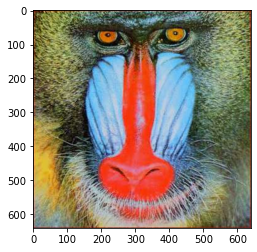

In [9]:
#plotting the image
plt.imshow(input_img)
plt.show()

Now that we have the image loaded and in the right size we want to cut it into tiles. We want the tiles to be the same size than the pictures from our Database. img_height, img_width, number of channels. (16X16X3)

To achieve this we select the height of the tiles and we loop over the width of the input image with steps the width of the tile. All of this while storing each tile into a list.
we have to repeat this process for the whole height of the input image and for every channel. 

with this process tile[0] (our first tile) will be the tile in the upper-left most corner.

In [10]:
tiles = []
for x in range(0, input_img_height,img_height): #we loop over the height of our tiles
    for y in range(0, input_img_width, img_width): # we loop over the width of our tiles
    
            tile = input_img[x:x+img_height,y:y+img_width,0:3] # we run the loop and cut within the 3 channels
            #we append each tile into the created list
            tiles.append(tile)

# our tile[0] is the tile in the upper-left side of our image

In [11]:
# let us check the lenght of the tiles list
len(tiles)

1600

Let us check if the tiles are correct

In [12]:
# let us check the shape of our tiles
tiles[0].shape

(16, 16, 3)

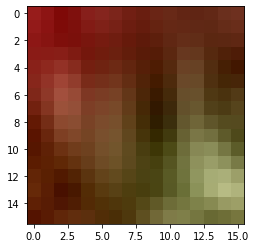

In [13]:
#let us have a visual of the tile
plt.imshow(tiles[0])
plt.show()

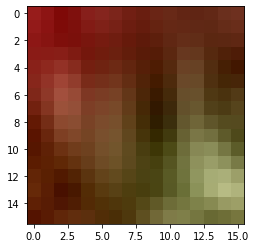

In [14]:
#we can compare the visual with the direct crop of the image. 
plt.imshow(input_img[0:16,0:16,0:3])
plt.show()

Both tiles seem to be the same. However, let us compare them numerically to make sure they are identical. 
We start by getting a boolean array for each pixel and we compute the sum to see if it is equal to the total size of the image.

In [15]:
#get the boolean array
check = tiles[0] == input_img[0:16, 0:16, 0:3]
# compute the sum: we are expecting as a result 16*16*3 = 768
check.sum()

768

Both tiles are equal!!! we can now create a new array with all the flattened tiles in it.  

In [16]:
tiles_array = []

for t in range(0,len(tiles)):
    
    # Now we flatten the tile and append it into the tiles_array. we do this by appending one pixel at a time. 
    flat_tile = tiles[t].reshape(768)
    for i in range(0,flat_tile.shape[0]):
        tiles_array.append(flat_tile[i])

In [17]:
#we check the lenght of the list that holds the new processed arrays. 
# we are looking for a list with lenght: 1,238,400 that we can reshape in the following way:
#1600 arrays and each array be of shape (1,774)
print(f'the tiles_array lenght is: {len(tiles_array)}')

#reshaping
tiles_array = np.array(tiles_array).reshape(1600,768)
print(f'tiles_arrray shape: {tiles_array.shape}')

the tiles_array lenght is: 1228800
tiles_arrray shape: (1600, 768)


# Matching the tile with an image in the database and rebuilding the full image

to compute find the match for every tile we need to iterate through the tiles array and through the images array and compare them using the cosine similarity. we select the highest cosine similarity and we match the tile with that image 

In [62]:
%%time
match_dic={}

for i in range(0, tiles_array.shape[0]):
    
    tile = tiles_array[i,:].reshape(1,768)
    
    # seting up the maximum back to 0
    maximum = 0
    
    #loop through each image
    for j in range(0,images_array.shape[0]):
        image = images_array[j].reshape(1,768)
    
        #calculating the cosine similarity with to find the best match
        cosine_similarities = cosine_similarity(tile, image)

        # once we have the cosine similarity calculated we need to find the maximum value 
        if cosine_similarities > maximum:
            maximum = cosine_similarities
            match_dic['tile{0}'.format(i)]= image
                
        else:
            continue

Wall time: 41min 53s


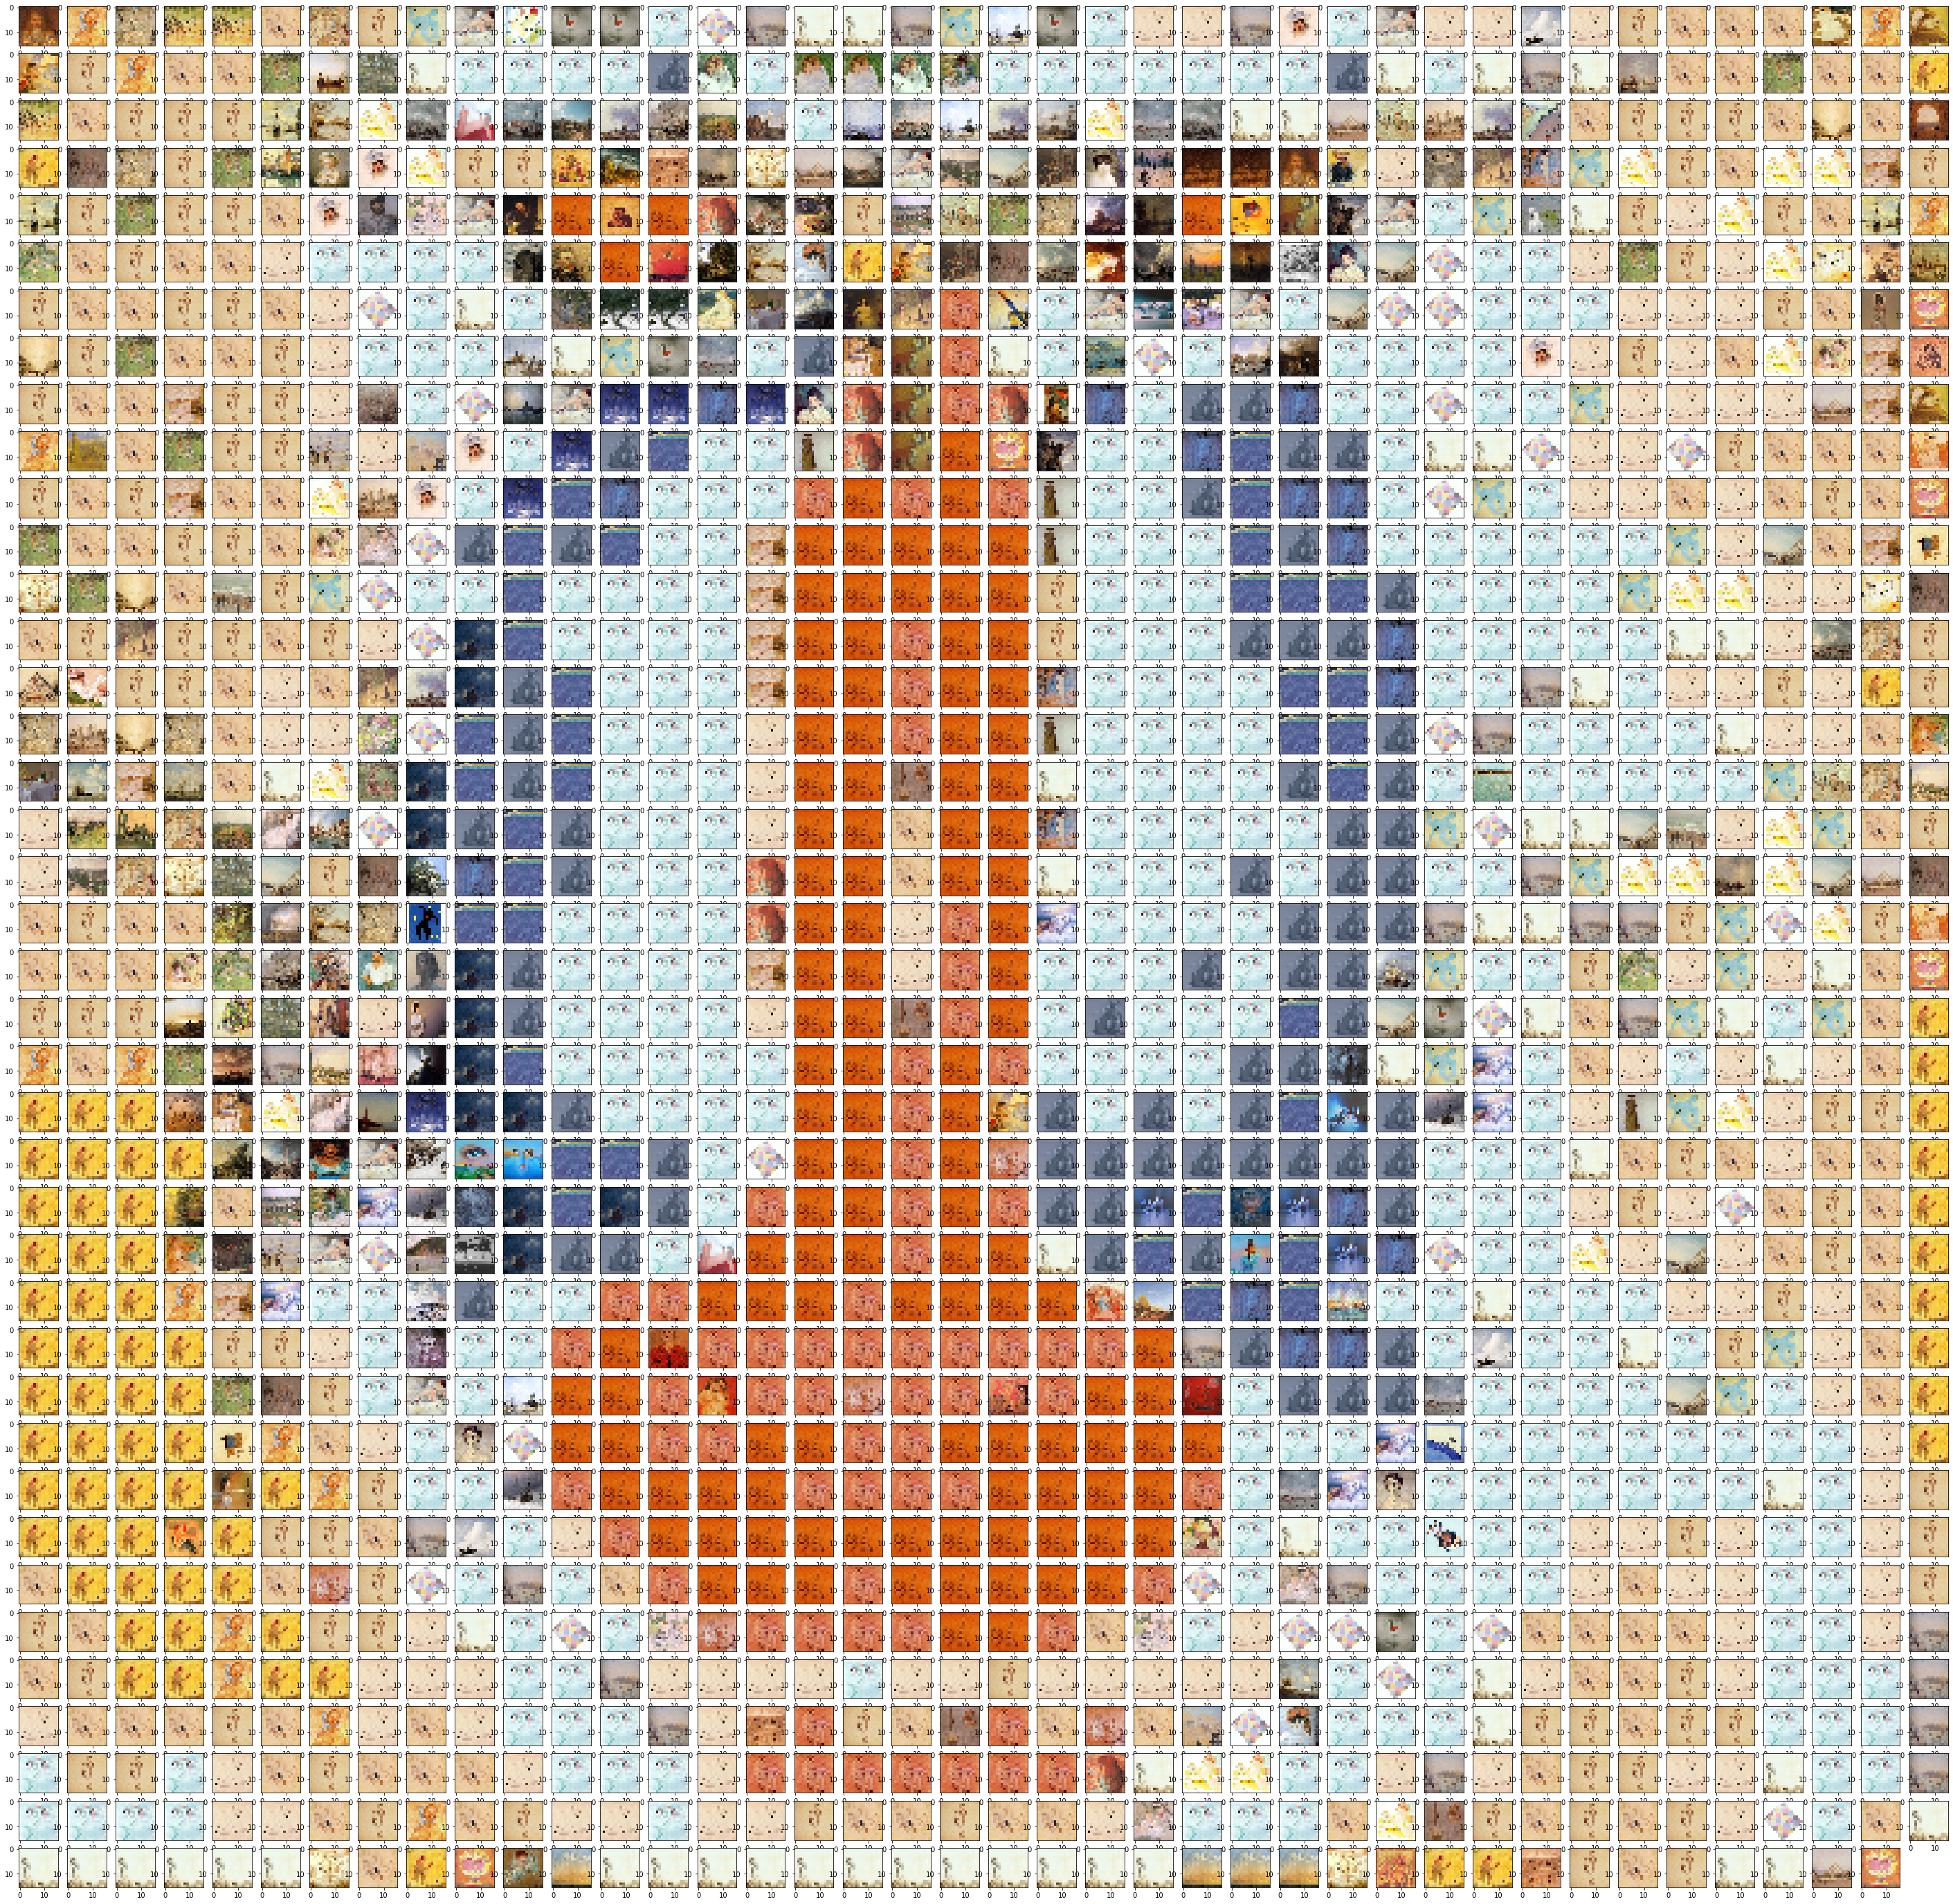

In [31]:
#using the dictionary that we created before we plot each painting as a tile and subplot to see the final result

fig=plt.figure(figsize = (50,50))

for i in range(1,1600):
    img = match_dic['tile{0}'.format(i)][:,:].reshape(16,16,3).astype('uint8')
    fig.add_subplot(40,40,i)
    plt.imshow(img)
plt.show() 

Our final result looks like the target image. However, it looks more like a cartoon version of the original. To enhance the quality we will include texture features into the model. 

## image array including mean and variance of histograms. 

The texture features that we are going to include are derived form the color histograms. We will compute the mean and variance of each histogram. The first step is to create a function to compute this features as shown bellow:

In [64]:
# definition of the mean and variance
def statistics(image_size,color_scale,hist):
    #image size,color scale in this case from 0 to 255, h is the color histogram.
    
    # calculating the mean
    freq=0
    for n in color_scale:
        freq += (n*hist[n]) 
    mean = freq/image_size
    
    #getting the variance
    freq2=0
    for n in color_scale:
        freq2 += (n-mean)**2*hist[n]
    variance = freq2/image_size
    
    return mean, variance

Now that we have the function to compute the mean and variance we need to load the images and for each one of them we compute the histogram for each channel. once we have the histogram we call upon the function that we defined before and append the features into the flattened image array.

In [65]:
#We will get a new array with the image features and the flattened image concatenated at the end to see if we get better results.  
# we will append everything into the images_array

images_array = []
image_id =  []

for folder in os.listdir(main_folder):
    for file in os.listdir(os.path.join(main_folder, folder)):
                
        path = os.path.join(main_folder, folder, file)
        img = cv2.imread(path,1) #select all the images in the folder
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #transform into RGB format
        img = cv2.resize(img, (img_width,img_height), interpolation = cv2.INTER_CUBIC) #rewsize each image 
        img = np.array(img).astype('uint8') # change data type to float
        
        for i in range(0,3):
            hist = cv2.calcHist([img],[i],None,[256],[0,256])
            #getting the mean, variance and skewness
            stats = statistics(256, range(0,256), hist)
            mean=stats[0]
            variance=stats[1]
            images_array.append(mean)
            images_array.append(variance)
        
        # Now we append the image into the images_array.
        flat_img = img.reshape(768)
        for i in range(0,flat_img.shape[0]):
            images_array.append(flat_img[i])
        
        # We also want to keep track of each individual image with an id
        image_id.append(path)

In [66]:
images_array = np.array(images_array)
print(f'the images_array has a shape of: {images_array.shape}')
#we reshape the array as follows to have one row per image. 
images_array = images_array.reshape(7694,774)
print(f'the new shape is {images_array.shape}')

the images_array has a shape of: (5955156,)
the new shape is (7694, 774)


Now that we have the images array we have to create the tiles array. to do this we will have to do the same processing that we did for the images.

In [67]:
tiles_array = []

for t in range(0,len(tiles)):
    for i in range(0,3):
        hist = cv2.calcHist(tiles[t],[i],None,[256],[0,256])
        #getting the mean, variance and skewness
        stats = statistics(256, range(0,256), hist)
        mean=stats[0]
        variance=stats[1]
        tiles_array.append(mean)
        tiles_array.append(variance)
        #images_array.append(skew)
        
    # Now we flatten the tile and append it into the tiles_array. we do this by appending one pixel at a time. 
    flat_tile = tiles[t].reshape(768)
    for i in range(0,flat_tile.shape[0]):
        tiles_array.append(flat_tile[i])

In [68]:
#we check the lenght of the list that holds the new processed arrays. 
# we are looking for a list with lenght: 1,238,400 that we can reshape in the following way:
#1600 arrays and each array be of shape (1,774)
print(f'the tiles_array lenght is: {len(tiles_array)}')

#reshaping
tiles_array = np.array(tiles_array).reshape(1600,774)
print(f'tiles_arrray shape: {tiles_array.shape}')

the tiles_array lenght is: 1238400
tiles_arrray shape: (1600, 774)


We do the same than before to find the cosine similarity. 

In [69]:
%%time
match_dic={}

for i in range(0, tiles_array.shape[0]):
    
    tile = tiles_array[i,:].reshape(1,774)
    
    # seting up the maximum back to 0
    maximum = 0
    
    #loop through each image of the given class array
    for j in range(0,images_array.shape[0]):
        image = images_array[j].reshape(1,774)
    
        #calculating the cosine similarity with to find the best match
        cosine_similarities = cosine_similarity(tile, image)

        # once we have the cosine similarity calculated we need to find the maximum value 
        if cosine_similarities > maximum:
            maximum = cosine_similarities
            match_dic['tile{0}'.format(i)]= image
                
        else:
            continue

Wall time: 50min 20s


We can see that the computational time took longer than the first cosine similarity. The process took 7 minutes more.

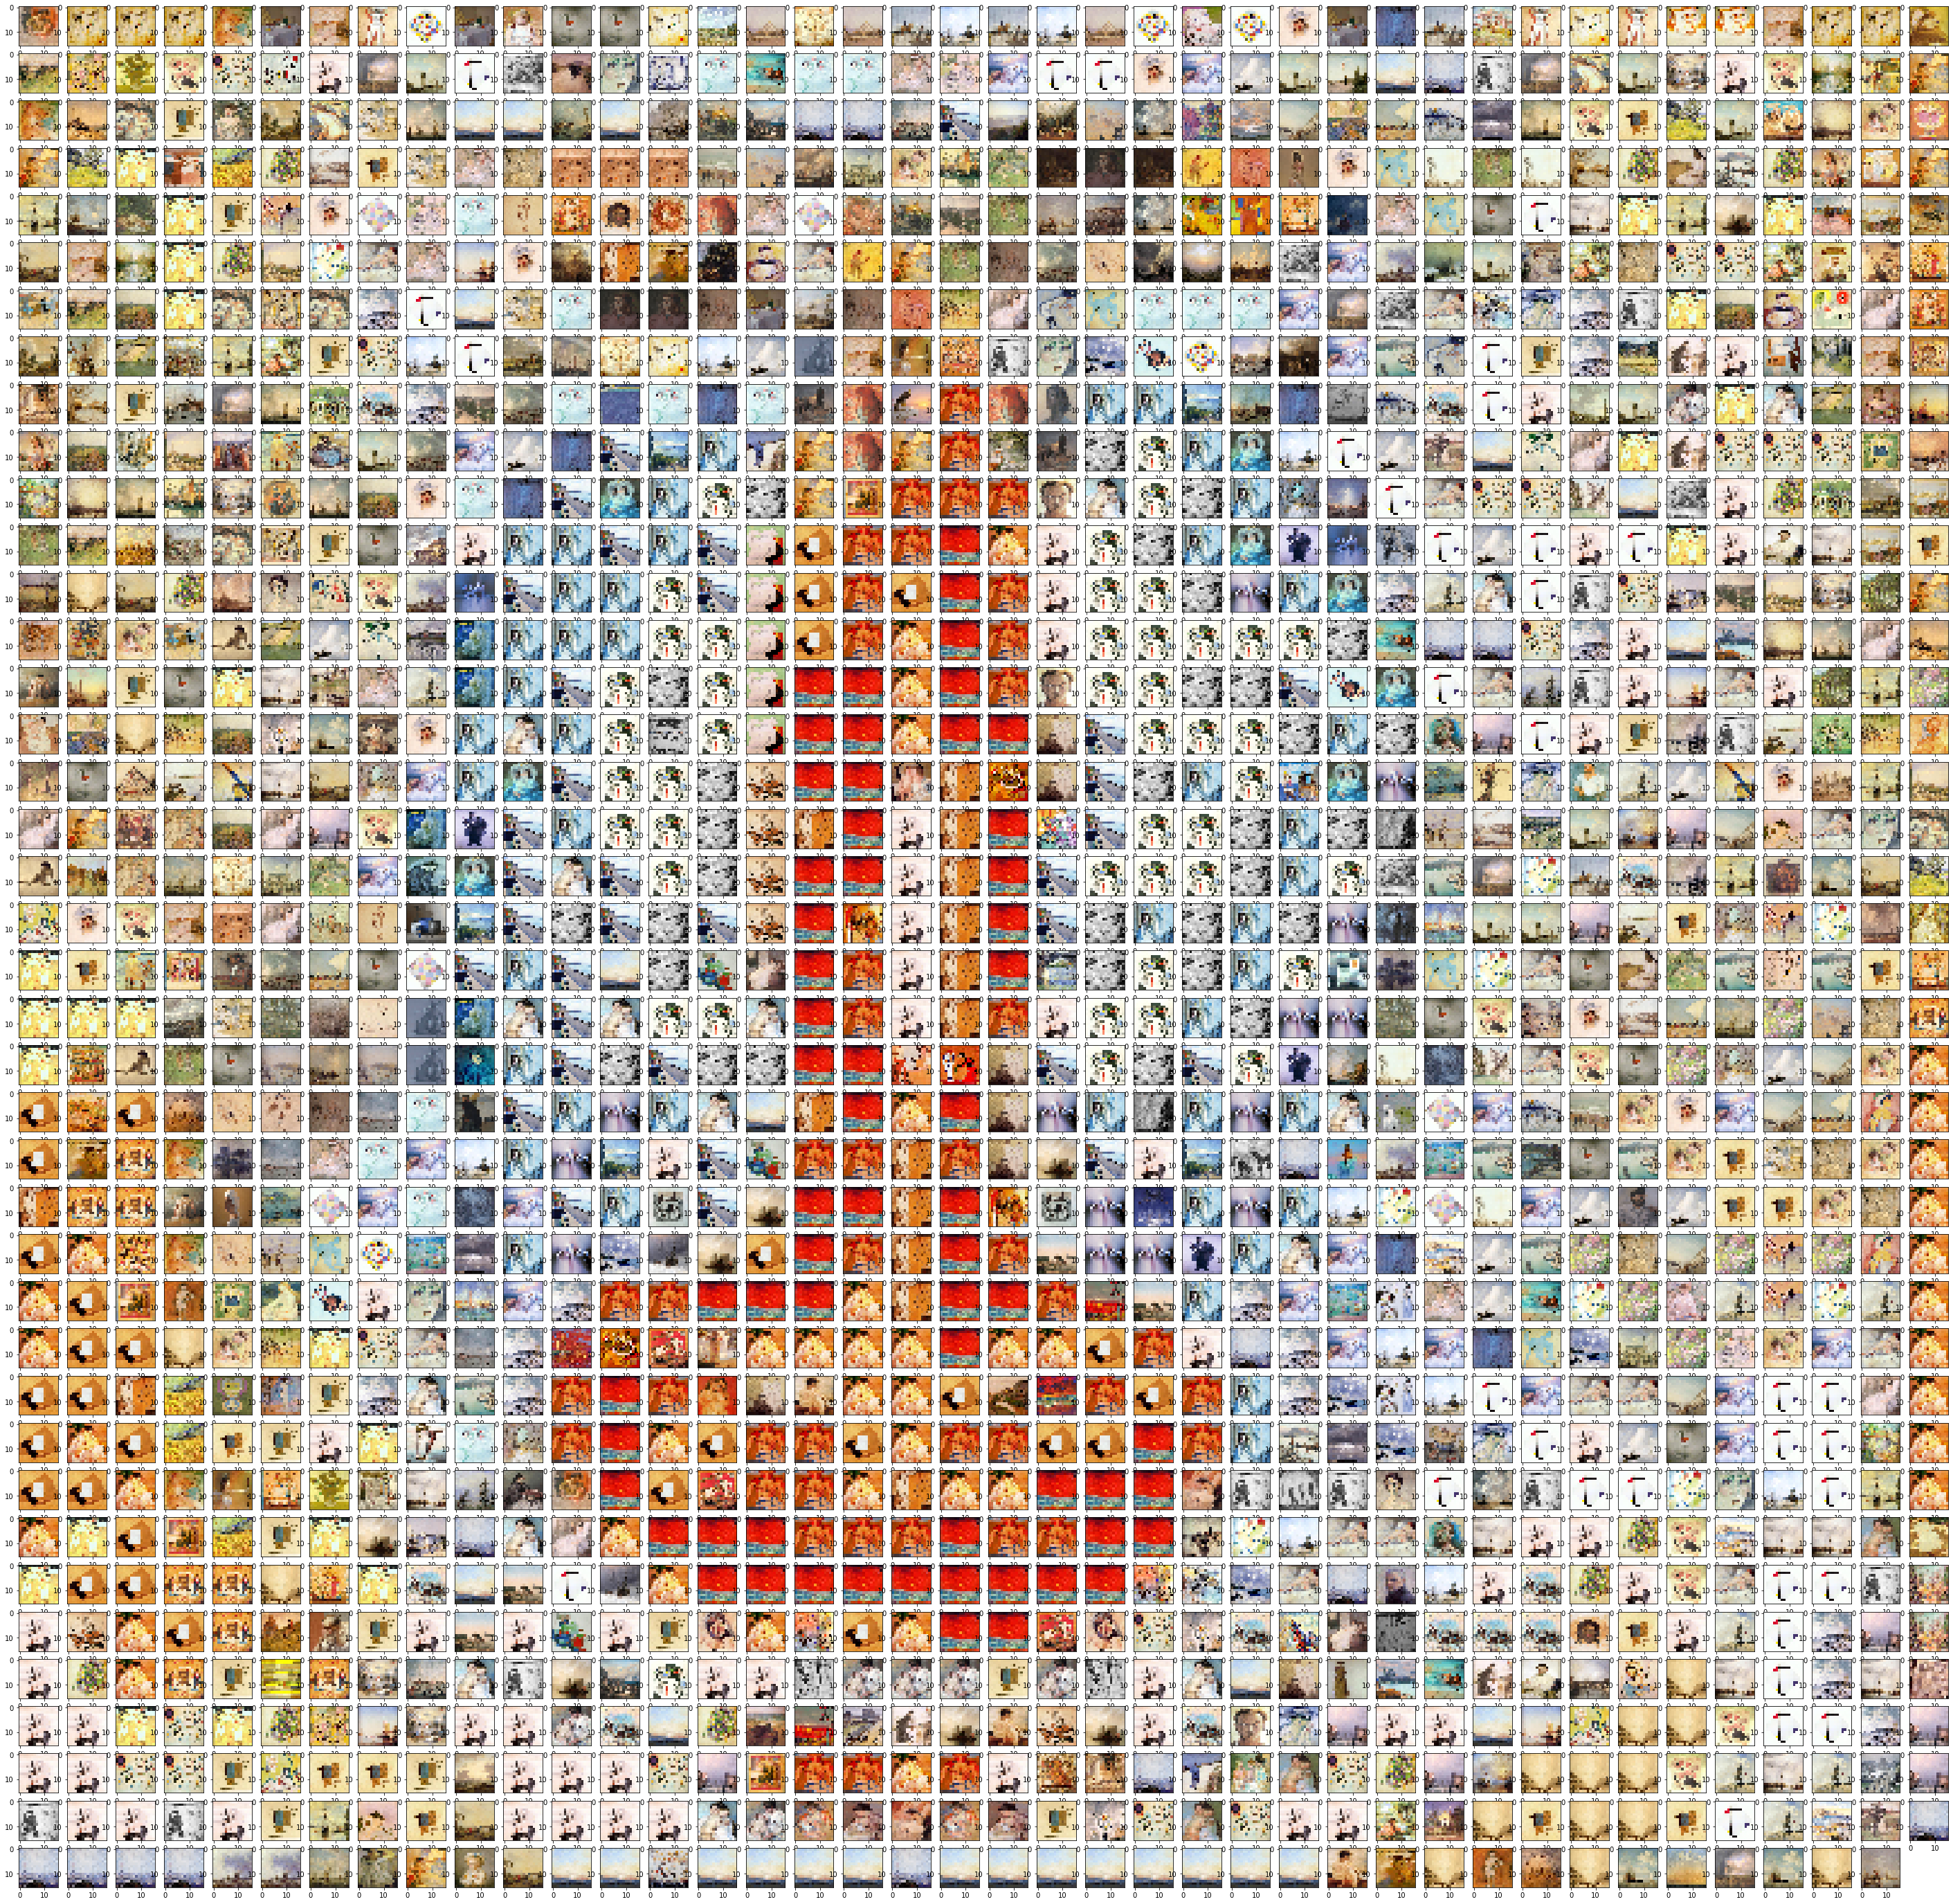

In [49]:
#using the dictionary that we created before we plot each painting as a tile and subplot to see the final result

fig=plt.figure(figsize = (50,50))

for i in range(1,1600):
    img = match_dic['tile{0}'.format(i)][:,6:].reshape(16,16,3).astype('uint8')
    fig.add_subplot(40,40,i)
    plt.imshow(img)
plt.show()

By adding the texture features the end result was a baboon that looks more lively and looks more like the one we computed before. 